# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dill
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from rich import print
from tqdm.auto import tqdm
from time import perf_counter
from operator import itemgetter
from scipy.stats import zscore
from Utils.Settings import window_spike_hist, output_folder_calculations, neuropixel_dataset, var_thr, minimum_ripples_count_spike_analysis, minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis
from Utils.Utils import acronym_to_main_area, clean_ripples_calculations, find_ripples_clusters_new, \
    batch_process_spike_hists_by_seed_location, process_spike_hists
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
import seaborn as sns
import pingouin as pg
from Utils.Utils import color_to_labels, color_to_labels_custom_palette
from Utils.Style import palette_ML
from Utils.Utils import acronym_color_map
from statannotations.Annotator import Annotator

/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
pd.set_option('display.max_rows',40)
pd.set_option('display.max_columns', None)

In [7]:
t1_start = perf_counter()

manifest_path = f'{neuropixel_dataset}/manifest.json'

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
#ProfileReport(sessions)

with open(f'{output_folder_calculations}/clean_ripples_calculations.pkl', 'rb') as f:
    ripples_calcs = dill.load(f)


spike_hists = {}

input_rip = []
for session_id in ripples_calcs.keys():
    ripples = ripples_calcs[session_id][3].copy()
    ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)
    input_rip.append(ripples.groupby('Probe number-area').mean()['L-R (µm)'])

lr_space = pd.concat(input_rip)

medial_lim = lr_space.quantile(.33333)
lateral_lim = lr_space.quantile(.666666)
center = lr_space.median()
medial_lim_lm = medial_lim - 5691.510009765625
lateral_lim_lm = lateral_lim - 5691.510009765625

def l_m_classifier(row):
    if row['Source M-L (µm)'] < medial_lim_lm:
        v = 'Medial'
    elif row['Source M-L (µm)'] > lateral_lim_lm:
        v = 'Lateral'
    else:
        v = 'Central'
    return v

In [8]:

all_areas_recorded = [item for sublist in  sessions['ecephys_structure_acronyms'].to_list() for item in sublist]

count_areas_recorded = pd.Series(all_areas_recorded).value_counts()

<AxesSubplot:>

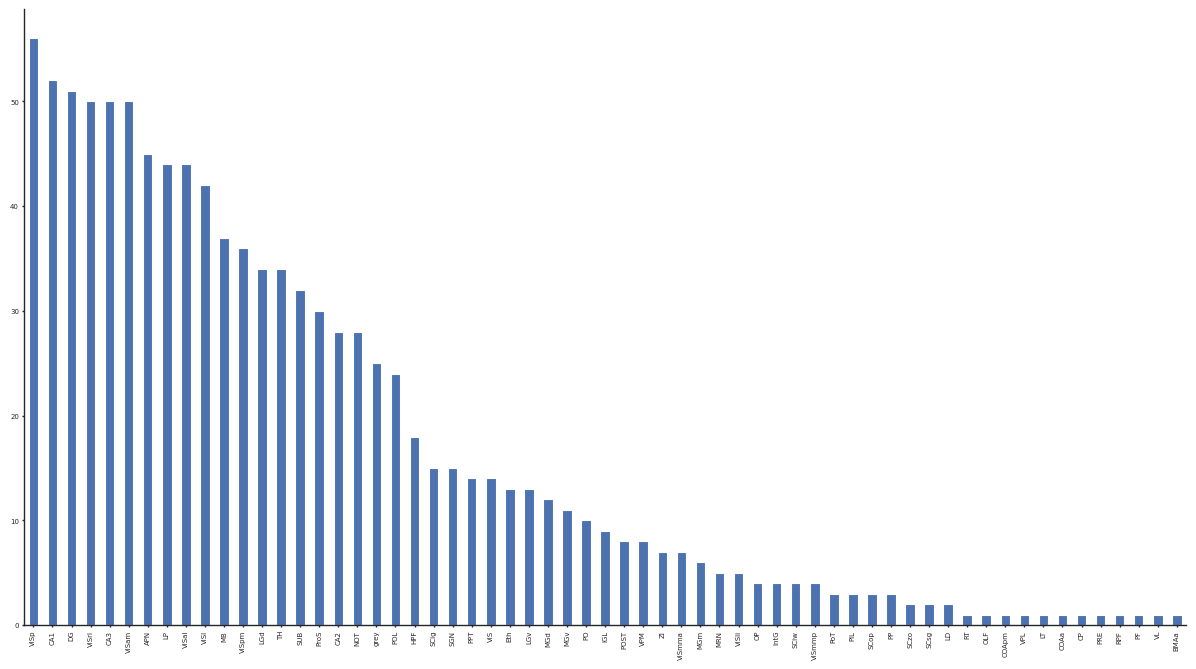

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
count_areas_recorded.plot.bar(ax=ax)


In [6]:
ripples_calcs.keys()

dict_keys([715093703, 719161530, 721123822, 743475441, 744228101, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 757216464, 757970808, 758798717, 759883607, 760345702, 761418226, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 840012044, 847657808])

In [177]:
Session id = 715093703
spikes_summary = {}

In [457]:
def process(Session id, spikes_summary):
    print(Session id)

    session = cache.get_session_data(Session id)  # , amplitude_cutoff_maximum = np.inf, presence_ratio_minimum = -np.inf, isi_violations_maximum = np.inf)

    units = session.units
    units['parent area'] = units['ecephys_structure_acronym'].apply(lambda area: acronym_to_main_area(area))


    # #  each area, change output name accordingly
    areas = np.delete(units['parent area'].unique(),
                      np.argwhere(units['parent area'].unique() == 'grey'))  # delete grey if present

    if 'HPF' in areas:
        areas = ['HPF']
    else:
        return

    print(f'In session {Session id} areas recorded: {areas}')

    spike_times = session.spike_times

    ripples = ripples_calcs[Session id][3].copy()

    sel_probe = ripples_calcs[Session id][5]

    print(f'number ripples on best probe: {ripples[ripples['Probe number'] == sel_probe].shape[0]}')

    if ripples[ripples['Probe number'] == sel_probe].shape[0] < minimum_ripples_count_spike_analysis:
        return

    ripples = ripples.groupby('Probe number-area').filter(lambda group: group['∫Ripple'].var() > var_thr)

    ripples = ripples.sort_values(by='Start (s)').reset_index(drop=True)
    ripples = ripples[ripples['Area'] == 'CA1']
    ripples = ripples.reset_index().rename(columns={'index': 'Ripple number'})

    print(Session id, 'Recording in each ML section:',
          np.any(ripples['L-R (µm)'].unique() < medial_lim) & np.any(ripples['L-R (µm)'].unique() > lateral_lim) & \
          np.any((ripples['L-R (µm)'].unique() > medial_lim) & (ripples['L-R (µm)'].unique() < lateral_lim)))

    if np.any(ripples['L-R (µm)'].unique() < medial_lim) & np.any(ripples['L-R (µm)'].unique() > lateral_lim) & \
            np.any((ripples['L-R (µm)'].unique() > medial_lim) & (ripples['L-R (µm)'].unique() < lateral_lim)) == False:
        return

    ripples['Local strong'] = ripples.groupby('Probe number').apply(
        lambda x: x['∫Ripple'] > x['∫Ripple'].quantile(.9)).sort_index(level=1).values

    try:
        ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
            lambda group: zscore(group['∫Ripple'], ddof=1)).droplevel(0)
    except:
        ripples['Z-scored ∫Ripple'] = ripples.groupby('Probe number-area').apply(
            lambda group: zscore(group['∫Ripple'], ddof=1)).T

    to_loop = []
    to_loop.append((ripples.groupby('Probe number-area').mean()['L-R (µm)'].sub(center).abs().idxmin(), 'central'))

    print(f'In session {Session id} process:{to_loop}')
    if ripples.shape[0] > 0:
        for source_area, type_source in to_loop:

            real_ripple_summary = find_ripples_clusters_new(ripples, source_area)
            real_ripple_summary = real_ripple_summary[real_ripple_summary['Spatial engagement']>.5]
            real_ripple_summary['Location seed'] = real_ripple_summary.apply(l_m_classifier, axis=1)

            print(f'in {Session id}, medial ripples number: {real_ripple_summary[real_ripple_summary['Location seed'] == 'Medial'].shape[0]}, ' \
                  f'lateral ripples number: {real_ripple_summary[real_ripple_summary['Location seed'] == 'Lateral'].shape[0]}')
            if (real_ripple_summary[real_ripple_summary['Location seed'] == 'Medial'].shape[0] < minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis) or \
                    (real_ripple_summary[real_ripple_summary['Location seed'] == 'Lateral'].shape[0] < minimum_ripples_count_generated_in_lateral_or_medial_spike_analysis):
                return

    field_to_use_to_compare = 'parent area'
    target_area = 'HPF'

    #space_sub_spike_times = dict(zip(units[units[field_to_use_to_compare] == target_area].index,
     #                                itemgetter(*units[units[field_to_use_to_compare] == target_area].index)(
     #                                    spike_times)))
    space_sub_spike_times = dict(zip(units.index,
                                     itemgetter(*units.index)(
                                         spike_times)))
    window = [.10, .12]
    spikes_per_ripple_medial = {}
    for cluster_id, spikes in tqdm(space_sub_spike_times.items()):
        _ = []
        ripple_start = []
        for index, row in real_ripple_summary[real_ripple_summary['Location seed'] == 'Medial'].iterrows():
            time_center = row['Start (s)'] + row[row.index.str.contains('lag')].min()# either sum zero or sum a negative value
            _.append(spikes[(spikes > time_center - window[0]) & (spikes < time_center + window[1])]-time_center)
            ripple_start.append(time_center)
        spikes_per_ripple_medial[cluster_id] = (_, ripple_start) 

    _ = [(key, np.concatenate(spikes_per_ripple_medial[key][0]), len(spikes_per_ripple_medial[key][0])) for key in spikes_per_ripple_medial.keys()]

    medial_ripple_firing_rate_0_120 = []
    medial_ripple_firing_rate_0_50 = []
    medial_ripple_firing_rate_50_120 = []
    medial_ripple_firing_rate_100_0 = []
    medial_ripple_firing_rate_20_0 = []
    medial_ripple_firing_rate_50_0 = []
    medial_ripple_firing_rate_100_20 = []
    for key, q, num_ripples in _:
        medial_ripple_firing_rate_0_120.append((key, ((len(q[q>0])/num_ripples)/12)))
        medial_ripple_firing_rate_0_50.append((key, ((len(q[(q>0) & (q<.05)])/num_ripples)/5)))
        medial_ripple_firing_rate_50_120.append((key, ((len(q[q>.05])/num_ripples)/7)))
        medial_ripple_firing_rate_100_0.append((key, ((len(q[(q>-.1) & (q<0)])/num_ripples)/10)))
        medial_ripple_firing_rate_20_0.append((key, ((len(q[(q>-.02) & (q<0)])/num_ripples)/2)))
        medial_ripple_firing_rate_50_0.append((key, ((len(q[(q>-.05) & (q<0)])/num_ripples)/5)))
        medial_ripple_firing_rate_100_20.append((key, ((len(q[(q>-.1) & (q<-.02)])/num_ripples)/8)))

    spikes_per_ripple_lateral = {}
    for cluster_id, spikes in tqdm(space_sub_spike_times.items()):
        _ = []
        ripple_start = []
        for index, row in real_ripple_summary[real_ripple_summary['Location seed'] == 'Lateral'].iterrows():
            time_center = row['Start (s)'] + row[row.index.str.contains('lag')].min()# either sum zero or sum a negative value
            _.append(spikes[(spikes > time_center - window[0]) & (spikes < time_center + window[1])]-time_center)
            ripple_start.append(time_center)
        spikes_per_ripple_lateral[cluster_id] = (_, ripple_start) 

    _ = [(key, np.concatenate(spikes_per_ripple_lateral[key][0]), len(spikes_per_ripple_lateral[key][0])) for key in spikes_per_ripple_lateral.keys()]

    lateral_ripple_firing_rate_0_120 = []
    lateral_ripple_firing_rate_0_50 = []
    lateral_ripple_firing_rate_50_120 = []
    lateral_ripple_firing_rate_100_0 = []
    lateral_ripple_firing_rate_20_0 = []
    lateral_ripple_firing_rate_50_0 = []
    lateral_ripple_firing_rate_100_20 = []
    for key, q, num_ripples in _:
        lateral_ripple_firing_rate_0_120.append((key, ((len(q[q>0])/num_ripples)/12)))
        lateral_ripple_firing_rate_0_50.append((key, ((len(q[(q>0) & (q<.05)])/num_ripples)/5)))
        lateral_ripple_firing_rate_50_120.append((key, ((len(q[q>.05])/num_ripples)/7)))
        lateral_ripple_firing_rate_100_0.append((key, ((len(q[(q>-.1) & (q<0)])/num_ripples)/10)))
        lateral_ripple_firing_rate_20_0.append((key, ((len(q[(q>-.02) & (q<0)])/num_ripples)/2)))
        lateral_ripple_firing_rate_50_0.append((key, ((len(q[(q>-.05) & (q<0)])/num_ripples)/5)))
        lateral_ripple_firing_rate_100_20.append((key, ((len(q[(q>-.1) & (q<-.02)])/num_ripples)/8)))


    mod_df = pd.concat([pd.DataFrame(medial_ripple_firing_rate_0_120, columns=['unit_id', 'Firing rate (0-120 ms) medial']), 
                        pd.DataFrame(medial_ripple_firing_rate_0_50, columns=['unit_id', 'Firing rate (0-50 ms) medial'])['Firing rate (0-50 ms) medial'],
                        pd.DataFrame(medial_ripple_firing_rate_50_120, columns=['unit_id', 'Firing rate (50-120 ms) medial'])['Firing rate (50-120 ms) medial'],
                       pd.DataFrame(medial_ripple_firing_rate_100_0, columns=['unit_id', 'Firing rate (100-0 ms) medial'])['Firing rate (100-0 ms) medial'],
                       pd.DataFrame(medial_ripple_firing_rate_20_0, columns=['unit_id', 'Firing rate (20-0 ms) medial'])['Firing rate (20-0 ms) medial'],
                       pd.DataFrame(medial_ripple_firing_rate_50_0, columns=['unit_id', 'Firing rate (50-0 ms) medial'])['Firing rate (50-0 ms) medial'],
                         pd.DataFrame(medial_ripple_firing_rate_100_20, columns=['unit_id', 'Firing rate (100-20 ms) medial'])['Firing rate (100-20 ms) medial'],
                       pd.DataFrame(lateral_ripple_firing_rate_0_120, columns=['unit_id', 'Firing rate (0-120 ms) lateral'])['Firing rate (0-120 ms) lateral'], 
                        pd.DataFrame(lateral_ripple_firing_rate_0_50, columns=['unit_id', 'Firing rate (0-50 ms) lateral'])['Firing rate (0-50 ms) lateral'],
                        pd.DataFrame(lateral_ripple_firing_rate_50_120, columns=['unit_id', 'Firing rate (50-120 ms) lateral'])['Firing rate (50-120 ms) lateral'],
                       pd.DataFrame(lateral_ripple_firing_rate_100_0, columns=['unit_id', 'Firing rate (100-0 ms) lateral'])['Firing rate (100-0 ms) lateral'],
                       pd.DataFrame(lateral_ripple_firing_rate_20_0, columns=['unit_id', 'Firing rate (20-0 ms) lateral'])['Firing rate (20-0 ms) lateral'],
                       pd.DataFrame(lateral_ripple_firing_rate_50_0, columns=['unit_id', 'Firing rate (50-0 ms) lateral'])['Firing rate (50-0 ms) lateral'],
                        pd.DataFrame(lateral_ripple_firing_rate_100_20, columns=['unit_id', 'Firing rate (100-20 ms) lateral'])['Firing rate (100-20 ms) lateral']],
                       axis=1).set_index('unit_id')
    out = pd.concat([units, mod_df], axis=1)#.groupby('ecephys_structure_acronym')[['modulation lat', 'modulation med']].mean()
    out['Session id'] = Session id
    spikes_summary[Session id] = out
    #print(out)
    return spikes_summary

In [586]:
%%time
_ = process(Session id, spikes_summary)


715093703

In session 715093703 areas recorded: ['HPF']

/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1348: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could "


number ripples on best probe: 3122

715093703 Recording in each ML section: True

In session 715093703 process:[('3-CA1', 'central')]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3450/3450 [00:41<00:00, 82.95it/s]


in 715093703, medial ripples number: 269, lateral ripples number: 389

  0%|          | 0/884 [00:00<?, ?it/s]

  0%|          | 0/884 [00:00<?, ?it/s]

CPU times: user 4min 45s, sys: 11.8 s, total: 4min 57s
Wall time: 5min 17s


In [ ]:
%%time 

In [459]:
manager = Manager()

spikes_summary = manager.dict()
input_multiprocessing = []
for ecephys_Session id in  list(ripples_calcs.keys())[::-1]:
        input_multiprocessing.append((ecephys_Session id, spikes_summary)) 

pool = Pool(processes=15) # Instantiate the pool here

pool.starmap_async(process, [x for x in input_multiprocessing])
pool.close()
pool.join()
print(len(spikes_summary))

In [460]:
spikes_summary = dict(spikes_summary)

In [ ]:
with open(f'{output_folder_calculations}/units_summary_with_added_metrics.pkl', 'wb') as f:
    dill.dump(spikes_summary, f)


## Load data

In [10]:
with open(f'{output_folder_calculations}/units_summary_with_added_metrics.pkl', 'rb') as f:
    spikes_summary = dill.load(f)

In [11]:
summary_units_df = pd.concat(spikes_summary.values())

neurons_per_area = summary_units_df.groupby('ecephys_structure_acronym').size()

summary_units_df['Ripple modulation (0-50 ms) medial'] = summary_units_df['Firing rate (0-50 ms) medial'] / summary_units_df['Firing rate (100-0 ms) medial']
summary_units_df['Ripple modulation (0-50 ms) lateral'] = summary_units_df['Firing rate (0-50 ms) lateral'] / summary_units_df['Firing rate (100-0 ms) lateral']
summary_units_df['Ripple modulation (50-120 ms) medial'] = summary_units_df['Firing rate (50-120 ms) medial'] / summary_units_df['Firing rate (100-0 ms) medial']
summary_units_df['Ripple modulation (50-120 ms) lateral'] = summary_units_df['Firing rate (50-120 ms) lateral'] / summary_units_df['Firing rate (100-0 ms) lateral']
summary_units_df['Ripple modulation (0-120 ms) medial'] = summary_units_df['Firing rate (0-120 ms) medial'] / summary_units_df['Firing rate (100-0 ms) medial']
summary_units_df['Ripple modulation (0-120 ms) lateral'] = summary_units_df['Firing rate (0-120 ms) lateral'] / summary_units_df['Firing rate (100-0 ms) lateral']

summary_units_df['Pre-ripple modulation medial'] = summary_units_df['Firing rate (20-0 ms) medial'] / summary_units_df['Firing rate (100-20 ms) medial'] 
summary_units_df['Pre-ripple modulation lateral'] = summary_units_df['Firing rate (20-0 ms) lateral'] /  summary_units_df['Firing rate (100-20 ms) lateral']


summary_units_df_sub = summary_units_df[(summary_units_df['ecephys_structure_acronym'].isin(count_areas_recorded[count_areas_recorded>8].index))&
                                        (summary_units_df['ecephys_structure_acronym'].isin(neurons_per_area[neurons_per_area>100].index))&
                                       (summary_units_df['ecephys_structure_acronym']!='grey')&
                                       (summary_units_df['ecephys_structure_acronym']!='HPF')]

summary_units_df_sub = summary_units_df_sub[~(summary_units_df_sub['Ripple modulation (0-50 ms) medial'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (0-50 ms) lateral'].isin([np.nan, np.inf, -np.inf])) &
                        ~(summary_units_df_sub['Ripple modulation (50-120 ms) medial'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (50-120 ms) lateral'].isin([np.nan, np.inf, -np.inf])) &
                        ~(summary_units_df_sub['Ripple modulation (0-120 ms) medial'].isin([np.nan, np.inf, -np.inf])) & 
                        ~(summary_units_df_sub['Ripple modulation (0-120 ms) lateral'].isin([np.nan, np.inf, -np.inf])) &
                        ~(summary_units_df_sub['Pre-ripple modulation medial'].isin([np.nan, np.inf, -np.inf]))&
                        ~(summary_units_df_sub['Pre-ripple modulation lateral'].isin([np.nan, np.inf, -np.inf]))]


summary_units_df_sub.columns = summary_units_df_sub.columns.str.replace('_', ' ')
summary_units_df_sub.columns = summary_units_df_sub.columns.str.capitalize()

summary_units_df_sub = summary_units_df_sub.rename(columns={"Left right ccf coordinate":"L-R", "Anterior posterior ccf coordinate":"A-P", "Dorsal ventral ccf coordinate":"D-V"})
summary_units_df_sub = summary_units_df_sub.rename(columns={"Ecephys structure acronym":"Brain region", "Parent area":"Parent brain region"})

summary_units_df_sub["M-L"] = summary_units_df_sub["L-R"] - 5691.510009765625

In [12]:
summary_units_df_sub['Diff pre-ripple modulation (20-0 ms)'] = (summary_units_df_sub['Pre-ripple modulation medial'] - summary_units_df_sub['Pre-ripple modulation lateral'])
summary_units_df_sub['Diff ripple modulation (0-50 ms)'] = (summary_units_df_sub['Ripple modulation (0-50 ms) medial'] - summary_units_df_sub['Ripple modulation (0-50 ms) lateral'])
summary_units_df_sub['Diff ripple modulation (50-120 ms)'] = (summary_units_df_sub['Ripple modulation (50-120 ms) medial'] - summary_units_df_sub['Ripple modulation (50-120 ms) lateral'])
summary_units_df_sub['Diff firing rate (0-50 ms)'] = (summary_units_df_sub['Firing rate (0-50 ms) medial'] - summary_units_df_sub['Firing rate (0-50 ms) lateral'])
summary_units_df_sub['Diff firing rate (50-120 ms)'] = (summary_units_df_sub['Firing rate (50-120 ms) medial'] - summary_units_df_sub['Firing rate (50-120 ms) lateral'])


In [ ]:
palette_parent_areas = dict()
for area in summary_units_df_sub['Parent brain region'].unique():
    palette_parent_areas[area] = '#' + ''.join(f'{i:02X}' for i in acronym_color_map[area]);

## how many neurons modulate by ripples

In [14]:
def conditions_type_engagement(s):
    if s['Ripple modulation (0-50 ms) medial']/s['Ripple modulation (0-50 ms) lateral']>2:
        return 'Medial ripple engagement'
    elif s['Ripple modulation (0-50 ms) lateral']/s['Ripple modulation (0-50 ms) medial']>2:
        return  'Lateral ripple engagement'
    else:
        return 'No preference'

def conditions_ripple_engagement(s):
    if (s['Ripple modulation (0-50 ms) medial']>2) | (s['Ripple modulation (0-50 ms) lateral']>2):
        return 'Ripple engagement'
    else:
        return 'No engagement'

In [15]:
parent_area = 'HPF'
summary_units_df_sub['Ripple type engagement'] = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)\
                                                                     ].apply(conditions_type_engagement, axis=1)
summary_units_df_sub['Ripple engagement'] = summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)\
                                                                 ].apply(conditions_ripple_engagement, axis=1)


Parent brain region  Ripple engagement
HPF                  No engagement        0.367532
                     Ripple engagement    0.632468
Isocortex            No engagement        0.984348
                     Ripple engagement    0.020870
MB                   No engagement        0.987969
                     Ripple engagement    0.060156
TH                   No engagement        0.998529
                     Ripple engagement    0.010786
Name: value, dtype: float64

In [16]:
pd.DataFrame(summary_units_df_sub.groupby(['Parent brain region', 'Session id'])['Ripple engagement'].value_counts(normalize=True))\
            .rename(columns={'Ripple engagement':'value'}).reset_index().groupby(['Parent brain region', 'Ripple engagement'])['value'].mean()

Parent brain region  Ripple engagement
HPF                  No engagement        0.015099
                     Ripple engagement    0.015099
Isocortex            No engagement        0.003282
                     Ripple engagement    0.003609
MB                   No engagement        0.005543
                     Ripple engagement    0.002839
TH                   No engagement        0.000814
                     Ripple engagement    0.000878
Name: value, dtype: float64

In [ ]:
pd.DataFrame(summary_units_df_sub.groupby(['Parent brain region', 'Session id'])['Ripple engagement'].value_counts(normalize=True))\
            .rename(columns={'Ripple engagement':'value'}).reset_index().groupby(['Parent brain region', 'Ripple engagement'])['value'].sem()

## many HPF are positivey ripple modulated 

In [18]:

def plot_dist_ripple_mod(data, param, ax0):
    g = sns.kdeplot(data=data, x=param, 
                    hue='Ripple seed', palette=palette_ML, ax=ax0, fill=True, gridsize=500, cut=0)
    ax0.set_xlim((0, 15))
    ax0.axvline(1,color= 'k', linestyle='--')
    ax0.axvline(2,color= 'r', linestyle='--')
    ax0.get_yaxis().set_visible(False) 

    ax0.spines[['left']].set_visible(False)


    norm_test = pg.normality(data=data, dv=param, group="Ripple seed")


    if norm_test["normal"].all():
        p_val = pg.ttest(data[data["Ripple seed"] == "Medial"][param],
               data[data["Ripple seed"] == "Lateral"][param])["p-val"][0]
        print("ttest: ", p_val)

    else:
        p_val = pg.mwu(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["p-val"][0]
        cles = pg.mwu(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["CLES"][0]
        print("mwu p-val and CLES: ", p_val, cles)

    if p_val<.05:
        ax0.text(.6, .7, "*",
                    transform=ax0.transAxes,
                    fontsize=15, ha='center', va='center');
        ax0.text(.6, .8,  f"p-value = {'{:.2e}'.format(p_val)}",
                        transform=ax0.transAxes,
                        fontsize=10, ha='center', va='center');



mwu p-val and CLES:  0.0005931219183518951 0.519973829227125

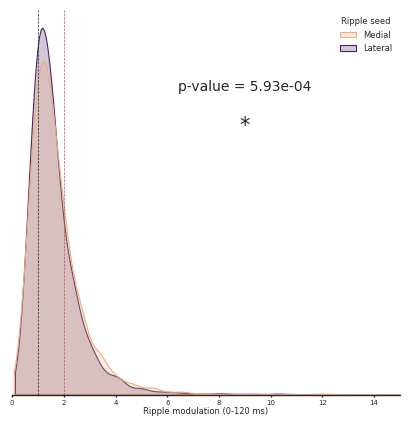

In [19]:
_ = summary_units_df_sub[['Ripple modulation (0-120 ms) medial', 'Ripple modulation (0-120 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (0-120 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()


mwu p-val and CLES:  5.6548557158679376e-05 0.4765833900012764

mwu p-val and CLES:  3.023196128290557e-90 0.6171434121061989

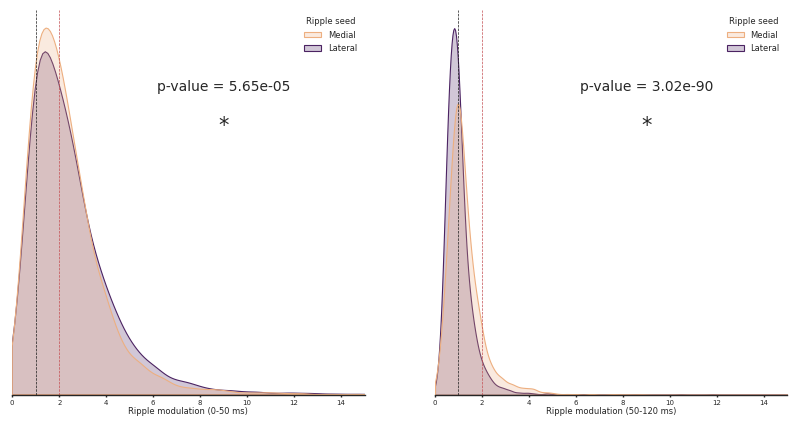

In [20]:
fig, ax0 = plt.subplots(1, figsize=(5,5))
data = _[_['Parent brain region']=='HPF']
param = 'Ripple modulation (0-120 ms)'
plot_dist_ripple_mod(data, param, ax0)

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

_ = summary_units_df_sub[['Ripple modulation (0-50 ms) medial', 'Ripple modulation (0-50 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (0-50 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()

data = _[_['Parent brain region']=='HPF']
param = 'Ripple modulation (0-50 ms)'
plot_dist_ripple_mod(data, param, axs[0])

_ = summary_units_df_sub[['Ripple modulation (50-120 ms) medial', 'Ripple modulation (50-120 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (50-120 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()

data = _[_['Parent brain region']=='HPF']
param = 'Ripple modulation (50-120 ms)'
plot_dist_ripple_mod(data, param, axs[1])

/alzheimer/Roberto/Software/mambaforge/envs/De-Filippo-et-al-2022/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


mwu p-val and CLES:  7.115912375719789e-27 0.5509525580020598

mwu p-val and CLES:  0.7761008748074992 0.5043941784810101

mwu p-val and CLES:  0.19482155117781708 0.5102458587776535

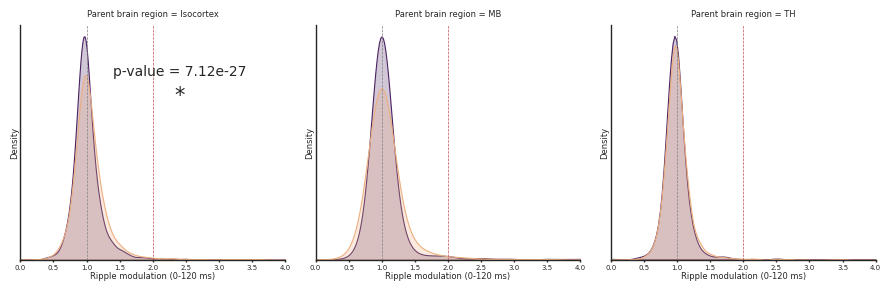

In [28]:
def func_annotate(data, **kws):
    ax0 = plt.gca()
    #print(data["Parent brain region"].unique())
    norm_test =pg.normality(data=data, dv=param, group="Ripple seed")
    
    if norm_test["normal"].all():
        p_val = pg.ttest(data[data["Ripple seed"] == "Medial"][param],
               data[data["Ripple seed"] == "Lateral"][param])["p-val"][0]
        print("ttest: ", p_val)

    else:
        p_val = pg.mwu(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["p-val"][0]
        cles = pg.mwu(data[data["Ripple seed"]=="Medial"][param], data[data["Ripple seed"]=="Lateral"][param])["CLES"][0]
        print("mwu p-val and CLES: ", p_val, cles)

    if p_val<.05:
        ax0.text(.6, .7, "*",
                    transform=ax0.transAxes,
                    fontsize=15, ha='center', va='center');
        ax0.text(.6, .8,  f"p-value = {'{:.2e}'.format(p_val)}",
                    transform=ax0.transAxes,
                    fontsize=10, ha='center', va='center');
       



In [29]:
_ = summary_units_df_sub[['Ripple modulation (0-120 ms) medial', 'Ripple modulation (0-120 ms) lateral', 'Parent brain region']]

_ = pd.wide_to_long(_.reset_index(), stubnames='Ripple modulation (0-120 ms)', i=['Parent brain region','unit_id'], j="Ripple seed", sep=' ', suffix=r'\w+').reset_index()
_['Ripple seed'] = _["Ripple seed"].str.capitalize()
param = 'Ripple modulation (0-120 ms)'
g = sns.FacetGrid(_[_['Parent brain region']!='HPF'], col='Parent brain region', sharex=False, sharey=False, col_order=['Isocortex', 'MB', 'TH'])
g.map_dataframe(sns.kdeplot, x='Ripple modulation (0-120 ms)', hue='Ripple seed', palette=palette_ML, fill=True, gridsize=500)
g.refline(x=1)
g.refline(x=2, color='r')
g.set(xlim=(0, 4))
g.set(yticks=[])
g.map_dataframe(func_annotate)

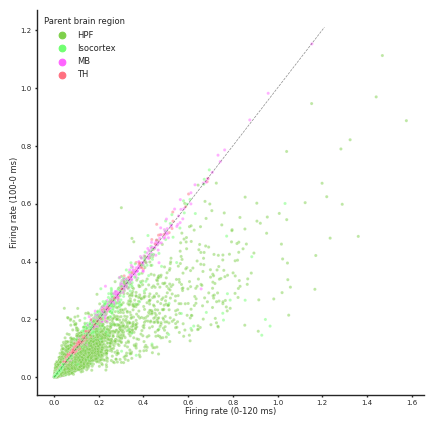

In [30]:
summary_units_df_sub['Firing rate (0-120 ms)'] = (summary_units_df_sub['Firing rate (0-120 ms) medial']+summary_units_df_sub['Firing rate (0-120 ms) lateral'])/2
summary_units_df_sub['Firing rate (100-0 ms)'] = (summary_units_df_sub['Firing rate (100-0 ms) medial']+summary_units_df_sub['Firing rate (100-0 ms) lateral'])/2

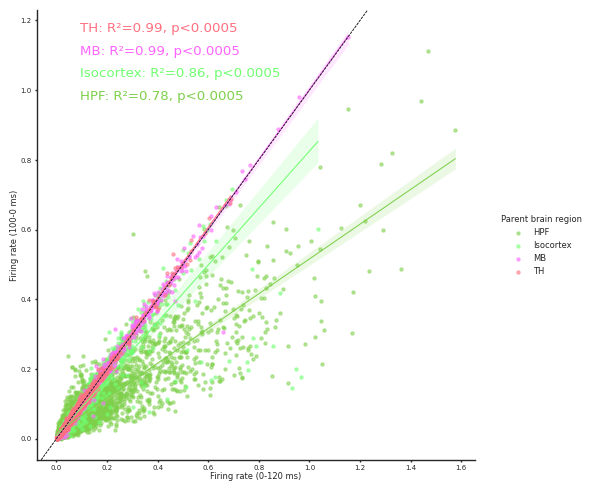

In [31]:
fig, axs = plt.subplots(1, figsize=(5,5))
sns.scatterplot(ax=axs, data=summary_units_df_sub, x='Firing rate (0-120 ms)', y='Firing rate (100-0 ms)', hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,
                hue_order=['HPF', 'Isocortex', 'MB', 'TH'])
axs.plot([0, axs.get_ylim()[1]], [0, axs.get_ylim()[1]],  alpha=.5, linestyle='--', color='k')

In [ ]:
import scipy as sp

g = sns.lmplot( data=summary_units_df_sub, x='Firing rate (0-120 ms)', y='Firing rate (100-0 ms)', hue='Parent brain region', 
           palette=palette_parent_areas, scatter_kws=dict( alpha=.5, s=5),
                hue_order=['HPF', 'Isocortex', 'MB', 'TH'], height=5, aspect=1)

yg = {'HPF':.8, 'Isocortex':.85, 'MB':.9, 'TH':.95}

def annotate(data, **kws):
    
    g = data['Parent brain region'].unique()[0]

    # get the y-position from the dict
    y = yg[g]

    r, p = sp.stats.pearsonr(data['Firing rate (0-120 ms)'], data['Firing rate (100-0 ms)'])
    ax = plt.gca()
    if p==0:
        ax.text(.1, y, f'{g}: R²={r**2:.2f}, p<0.0005', transform = ax.transAxes, color=palette_parent_areas[g])
    else:  
        ax.text(.1, y, f'{g}: R²={r**2:.2f}, p={2:.2e}', transform = ax.transAxes, color=palette_parent_areas[g])
    
g.map_dataframe(annotate)
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1,  alpha=.5, linestyle='--', color='k'))

Text(0.5, 1.0, 'firing rate post-ripple start')

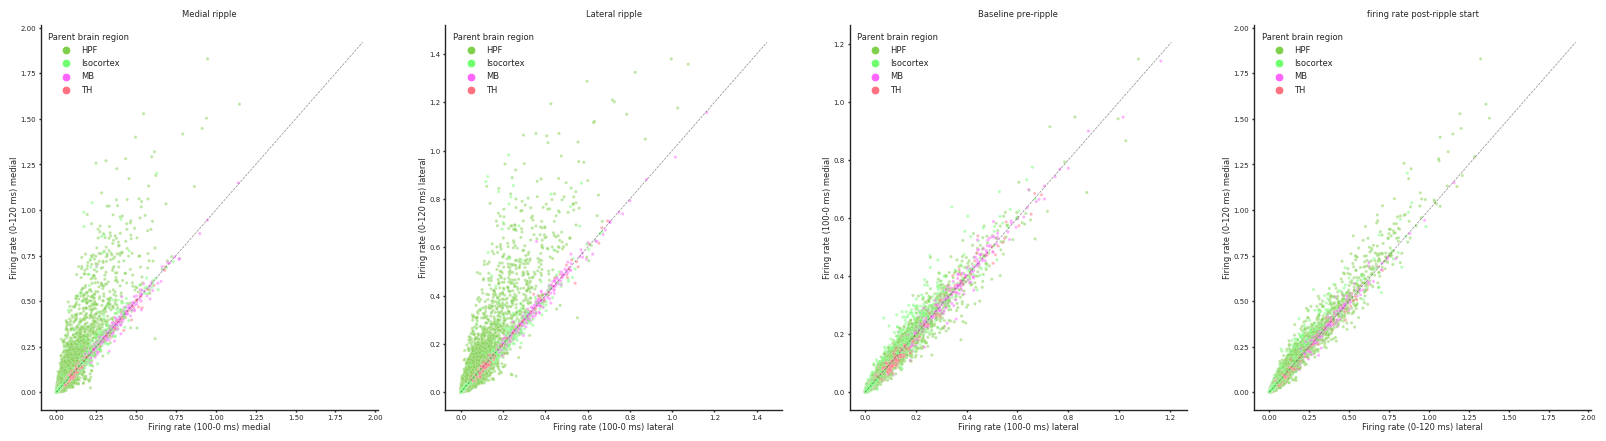

In [33]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
sns.scatterplot(ax=axs[0], data=summary_units_df_sub, x='Firing rate (100-0 ms) medial', y='Firing rate (0-120 ms) medial', hue='Parent brain region', 
                palette=palette_parent_areas, alpha=.5, s=5, 
                hue_order=['HPF', 'Isocortex', 'MB', 'TH'])
axs[0].plot([0, axs[0].get_ylim()[1]], [0, axs[0].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[0].set_title("Medial ripple")
sns.scatterplot(ax=axs[1], data=summary_units_df_sub, x='Firing rate (100-0 ms) lateral', y='Firing rate (0-120 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,  hue_order=['HPF', 'Isocortex', 'MB', 'TH']
               )
axs[1].plot([0, axs[1].get_ylim()[1]], [0, axs[1].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[1].set_title("Lateral ripple")


sns.scatterplot(ax=axs[2], data=summary_units_df_sub, y='Firing rate (100-0 ms) medial', x='Firing rate (100-0 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,  hue_order=['HPF', 'Isocortex', 'MB', 'TH']
               )
axs[2].plot([0, axs[2].get_ylim()[1]], [0, axs[2].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[2].set_title("Baseline pre-ripple")

sns.scatterplot(ax=axs[3], data=summary_units_df_sub, y="Firing rate (0-120 ms) medial", x="Firing rate (0-120 ms) lateral", hue='Parent brain region', palette=palette_parent_areas, alpha=.5, s=5,  hue_order=['HPF', 'Isocortex', 'MB', 'TH']
               )
axs[3].plot([0, axs[3].get_ylim()[1]], [0, axs[3].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[3].set_title("firing rate post-ripple start")

,Ripple modulation (0-120 ms) medial,Ripple modulation (0-120 ms) lateral
Ripple modulation (0-120 ms) medial,1.000000,0.457722
Ripple modulation (0-120 ms) lateral,0.457722,1.000000


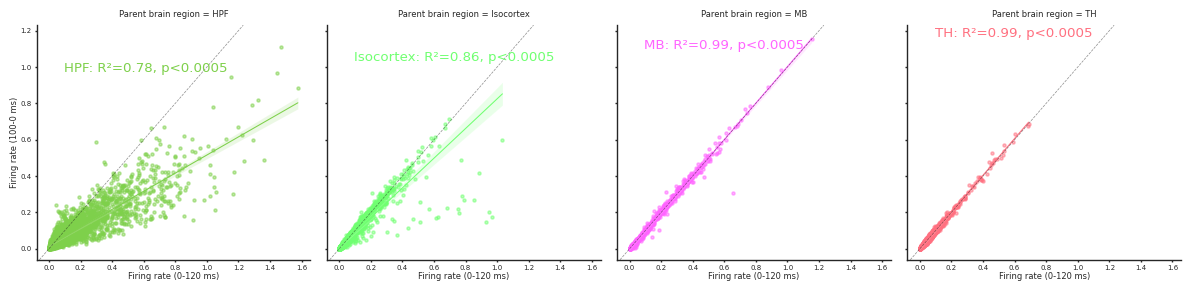

In [34]:
summary_units_df_sub[['Ripple modulation (0-120 ms) medial', 'Ripple modulation (0-120 ms) lateral']].corr()**2

In [35]:
g = sns.FacetGrid(summary_units_df_sub, col='Parent brain region', hue='Parent brain region', palette=palette_parent_areas, col_order=['HPF', 'Isocortex', 'MB', 'TH'])
g.map_dataframe(sns.regplot, x='Firing rate (0-120 ms)', y='Firing rate (100-0 ms)', scatter_kws=dict(s=5, alpha=.5))
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1,  alpha=.5, linestyle='--', color='k'))

def annotate(data, **kws):
    
    g = data['Parent brain region'].unique()[0]

    # get the y-position from the dict
    y = yg[g]

    r, p = sp.stats.pearsonr(data['Firing rate (0-120 ms)'], data['Firing rate (100-0 ms)'])
    ax = plt.gca()
    if p==0:
        ax.text(.1, y, f'{g}: R²={r**2:.2f}, p<0.0005', transform = ax.transAxes, color=palette_parent_areas[g])
    else:  
        ax.text(.1, y, f'{g}: R²={r**2:.2f}, p={2:.2e}', transform = ax.transAxes, color=palette_parent_areas[g])
    
g.map_dataframe(annotate)

In [36]:
PROPS = {
    'medianprops':{'color':'white'},
}


In [42]:
palette_HPF = {'DG':'#2292A4', 'CA3':'#FF4365', 'CA1':'#754668', 'ProS':'#EAC435', 'SUB':'#04080F'}

In [ ]:
def point_plot_modulation_ripples(data, dv, parent_area, order, filter_spiking, axs, ylabel, ylim = [.5,3] , palette=palette_HPF):

    _ = data[(filter_spiking) & (data['Parent brain region']==parent_area )].reset_index()[['Firing rate','unit_id','M-L',
                                                                                                                    'Session id', 'Brain region', dv + ' medial', dv + ' lateral']]
    _ = pd.wide_to_long(_.reset_index(), stubnames=dv, i=['Brain region','index'], j='Type', sep=' ', suffix=r'\w+').reset_index()
    _['Type'] = _['Type'].str.capitalize()


    ax = sns.pointplot(data=_, x='Brain region', y=dv, hue='Type', dodge=.5, errorbar='se',join=False,  palette=palette_ML, ax=axs, capsize=.2, order=order)
    ax.axhline(1,color= 'k', linestyle='--')
    color_to_labels_custom_palette(ax, 'x', 'major', palette, 1)
    plt.xticks(rotation=45, ha='center')
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)

    stat = []
    for area in _['Brain region'].unique():
        sub = _[_['Brain region']==area]
        if pg.normality(sub, group='Type', dv=dv)['normal'].all():
            test = pg.ttest(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv])['p-val']
        else:
            test = pg.mwu(sub[sub['Type']=='Medial'][dv], sub[sub['Type']=='Lateral'][dv])['p-val']

        if test[0] < .05:
            stat.append(((area, 'Medial'), (area, 'Lateral')))

    if len(stat)>0:
        annot = Annotator(ax, data=_, pairs= stat,
                           x='Brain region', y=dv, hue='Type', order=order)
        (annot
         .configure(test=None, test_short_name='custom test',  text_format='star', loc='inside', verbose=0)
         .set_pvalues(pvalues=[.3]*len(stat))
         .set_custom_annotations(['*']*len(stat))
         .annotate());
#axs[1].text(.6, .7, 'Cohen's d: ' + str(round(ttest_late_spiking['cohen-d'].values[0], 2)), transform=axs[1].transAxes,fontsize=6, ha='center', va='center');

## ripple mod per area

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

parent_area='HPF'
order= ['CA1',  'CA3', 'DG', 'ProS', 'SUB']

dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[0], ylabel)
axs[0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[1], ylabel)



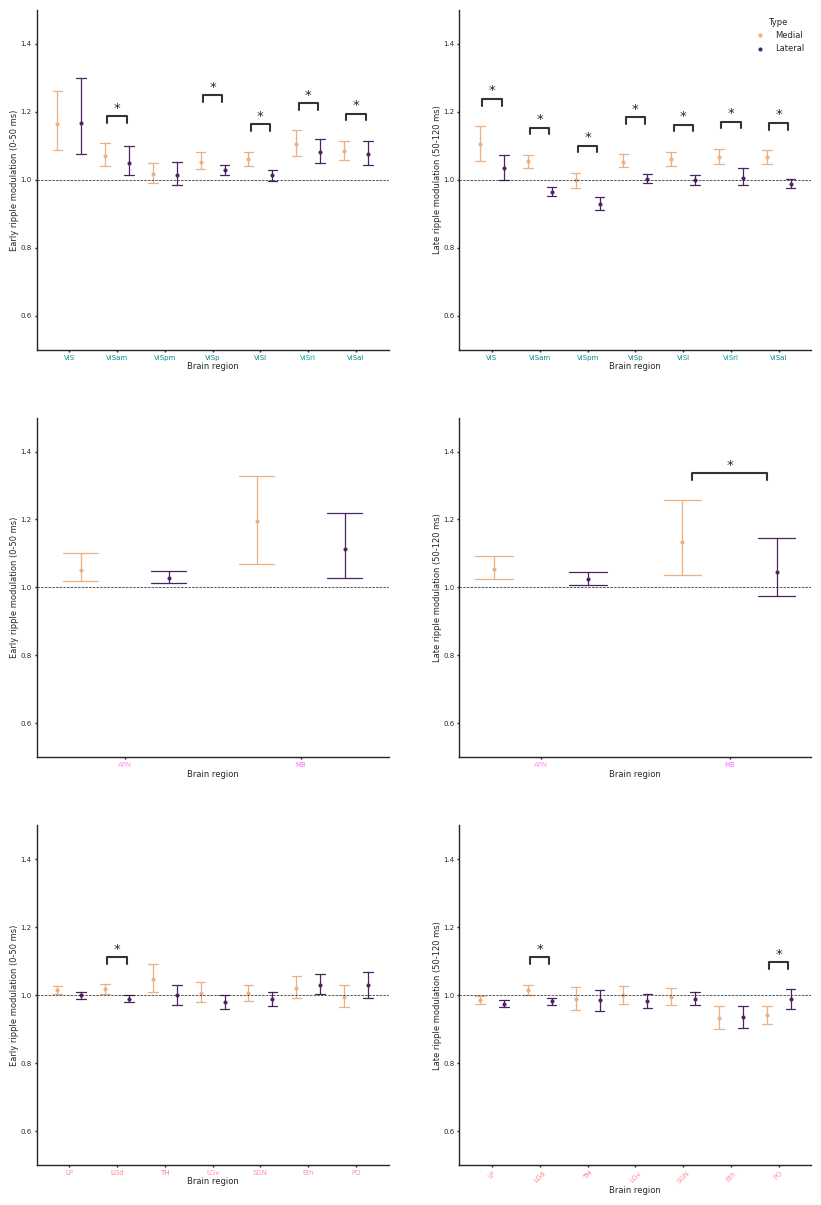

In [48]:
palette_areas = dict()
for area in summary_units_df_sub['Brain region'].unique():
    palette_areas[area] = '#' + ''.join(f'{i:02X}' for i in acronym_color_map[area]);

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,15))

parent_area='Isocortex'
order= ['VIS', 'VISam', 'VISpm', 'VISp', 'VISl', 'VISrl', 'VISal']
ylim= [0.5,1.5]
dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[0,0], ylabel,ylim ,palette_areas)
axs[0,0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[0,1], ylabel,ylim,  palette_areas)


parent_area='MB'
order= ['APN', 'MB']

dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[1, 0], ylabel,ylim, palette_areas)
axs[1, 0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[1, 1], ylabel,ylim, palette_areas)
axs[1, 1].get_legend().remove()


parent_area='TH'
order= ['LP', 'LGd', 'TH', 'LGv', 'SGN', 'Eth', 'PO']

dv = 'Ripple modulation (0-50 ms)'
ylabel = 'Early ripple modulation (0-50 ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[2, 0], ylabel,ylim, palette_areas)
axs[2,0].get_legend().remove()
dv = 'Ripple modulation (50-120 ms)'
ylabel = 'Late ripple modulation (50-120 ms)'
point_plot_modulation_ripples(summary_units_df_sub, dv,parent_area, order, filter_spiking,axs[2, 1], ylabel,ylim, palette_areas)
axs[2,1].get_legend().remove()

## preripple mod per area

In [431]:
fig, axs = plt.subplots(1,3,  figsize=(15,5))

ylim = [.5, 1.5]
parent_area='Isocortex'
order= ['VIS', 'VISam', 'VISpm', 'VISp', 'VISl', 'VISrl', 'VISal']

dv = 'Pre-ripple modulation'
ylabel = 'Pre-ripple modulation (20-0ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[0], ylabel,ylim, palette_areas)

parent_area='MB'
order= ['APN', 'MB']

dv = 'Pre-ripple modulation'
ylabel = 'Pre-ripple modulation (20-0ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[1], ylabel, ylim,palette_areas)

parent_area='TH'
order= ['LP', 'LGd', 'TH', 'LGv', 'SGN', 'Eth', 'PO']

dv = 'Pre-ripple modulation'
ylabel='Pre-ripple modulation (20-0ms)'
filter_spiking = summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025
point_plot_modulation_ripples(summary_units_df_sub, dv, parent_area, order,filter_spiking,axs[2], ylabel, ylim,palette_areas)


,L ratio,Waveform halfwidth,Waveform recovery slope,Peak channel id,Cluster id,Nn miss rate,Waveform duration,Max drift,Local index unit,Amplitude cutoff,Firing rate,Waveform repolarization slope,Waveform velocity above,D prime,Waveform pt ratio,Snr,Isolation distance,Waveform spread,Cumulative drift,Silhouette score,Isi violations,Waveform velocity below,Presence ratio,Nn hit rate,Waveform amplitude,C50 dg,Area rf,Fano dg,Fano dm,Fano fl,Fano rf,F1 f0 dg,G dsi dg,G osi dg,Azimuth rf,Mod idx dg,P value rf,Pref tf dg,Run mod dg,Run mod dm,Run mod fl,Run mod rf,Pref dir dm,Pref ori dg,Run pval dg,Run pval dm,Run pval fl,Run pval rf,Elevation rf,Pref speed dm,Firing rate dg,Firing rate dm,Firing rate fl,Firing rate rf,On off ratio fl,Time to peak dm,Pref tf multi dg,Pref dir multi dm,Pref ori multi dg,Pref speed multi dm,Lifetime sparseness dg,Lifetime sparseness dm,Lifetime sparseness fl,Lifetime sparseness rf,Probe vertical position,Probe horizontal position,Probe id,Channel local index,Ecephys structure id,Brain region,A-P,D-V,L-R,Probe description,Location,Probe sampling rate,Probe lfp sampling rate,Probe has lfp data,Parent brain region,Firing rate (0-120 ms) medial,Firing rate (0-50 ms) medial,Firing rate (50-120 ms) medial,Firing rate (100-0 ms) medial,Firing rate (20-0 ms) medial,Firing rate (50-0 ms) medial,Firing rate (100-20 ms) medial,Firing rate (0-120 ms) lateral,Firing rate (0-50 ms) lateral,Firing rate (50-120 ms) lateral,Firing rate (100-0 ms) lateral,Firing rate (20-0 ms) lateral,Firing rate (50-0 ms) lateral,Firing rate (100-20 ms) lateral,Session id,Fano ns,Fano sg,G osi sg,Pref sf sg,Run mod ns,Run mod sg,Pref ori sg,Run pval ns,Run pval sg,Pref image ns,Pref phase sg,Firing rate ns,Firing rate sg,Time to peak ns,Pref sf multi sg,Pref ori multi sg,Pref phase multi sg,Image selectivity ns,Pref image multi ns,Lifetime sparseness ns,Lifetime sparseness sg,Ripple modulation (0-50 ms) medial,Ripple modulation (0-50 ms) lateral,Ripple modulation (50-120 ms) medial,Ripple modulation (50-120 ms) lateral,Ripple modulation (0-120 ms) medial,Ripple modulation (0-120 ms) lateral,Pre-ripple modulation medial,Pre-ripple modulation lateral,M-L,Diff pre-ripple modulation (20-0 ms),Diff ripple modulation (0-50 ms),Diff ripple modulation (50-120 ms),Diff firing rate (0-50 ms),Diff firing rate (50-120 ms),Ripple type engagement,Ripple engagement,Firing rate (0-50 ms),Firing rate (100-0 ms),Firing rate (0-120 ms)
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
951171690,0.010382,0.219765,-0.065294,868930110,312,0.002060,0.673032,63.49,300,0.000740,1.893987,0.319203,0.255085,3.851051,0.425041,1.220540,51.315650,80.0,143.77,0.061186,0.093279,3.433836e-01,0.99,0.949599,139.00848,0.034671,100.0,5.003077,5.266667,1.673333,3.390476,0.346905,NaN,NaN,70.000,0.432189,0.020,2.0,-0.233894,-0.769231,NaN,-1.000000,90.0,0.0,0.211371,0.450047,NaN,0.189081,0.000,0.0200,2.496256,0.555164,0.559534,0.241231,NaN,0.5755,False,False,False,False,0.745299,0.428839,0.040000,0.645709,2460,11,841435557,245,394.0,VISam,7495.0,645.0,7639.0,probeA,See electrode locations,30000.288456,1250.012019,True,Isocortex,0.013889,0.017333,0.011429,0.011333,0.010000,0.014667,0.011667,0.019707,0.028378,0.013514,0.010135,0.006757,0.012162,0.010980,839068429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.529412,2.800000,1.008403,1.333333,1.225490,1.944444,0.857143,0.615385,1947.48999,0.241758,-1.270588e+00,-0.324930,-0.011045,-0.002085,NaN,NaN,0.022856,0.010734,0.016798
951172317,0.011330,0.233501,-0.028203,868931342,248,0.001860,0.618090,59.77,243,0.008443,1.535904,0.167304,1.412778,3.557056,0.591138,1.673657,45.847714,90.0,200.95,0.105725,0.189125,3.433836e-01,0.99,0.875587,75.45252,NaN,2200.0,8.589316,2.454902,0.960000,2.800000,1.401051,NaN,NaN,71.818,7.732914,0.659,2.0,0.923333,NaN,NaN,1.000000,-45.0,135.0,0.000462,NaN,NaN,0.422650,19.545

In [ ]:
summary_units_df_sub[(summary_units_df_sub["Parent brain region"]=="Isocortex") &
                    (summary_units_df_sub['Ripple modulation (0-50 ms) lateral']>2)]

In [ ]:
from scipy.stats import pearsonr

In [37]:
def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

7772.97056

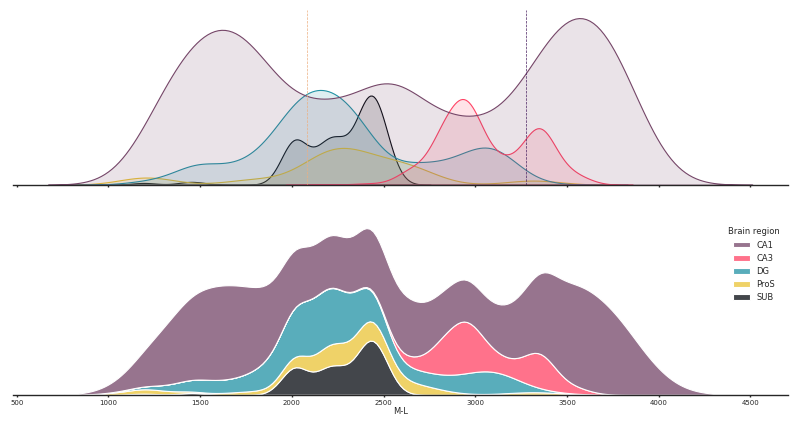

In [38]:
medial_lim

In [39]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
sns.kdeplot(ax=axs[0], data=summary_units_df_sub[ summary_units_df_sub['Parent brain region']=='HPF'],
            hue='Brain region', x='M-L',  palette=palette_HPF, fill=True,  alpha=.15, hue_order=['CA1',  'CA3', 'DG', 'ProS', 'SUB'], legend=False)
sns.kdeplot(ax=axs[1], data=summary_units_df_sub[ summary_units_df_sub['Parent brain region']=='HPF'],
            hue='Brain region', x='M-L',  palette=palette_HPF, multiple='stack', hue_order=['CA1',  'CA3', 'DG', 'ProS', 'SUB'])
axs[0].get_yaxis().set_visible(False) 
axs[1].get_yaxis().set_visible(False)
axs[0].spines[['left']].set_visible(False)
axs[1].spines[['left']].set_visible(False)
axs[0].axvline(medial_lim - 5691.510009765625,  color= palette_ML["Medial"], linestyle='--')
axs[0].axvline(lateral_lim - 5691.510009765625,  color= palette_ML["Lateral"], linestyle='--')


,Diff pre-ripple modulation (20-0 ms),Diff ripple modulation (0-50 ms),Diff ripple modulation (50-120 ms),Diff firing rate (0-50 ms),Ripple modulation (0-50 ms) medial,Ripple modulation (0-50 ms) lateral
Diff pre-ripple modulation (20-0 ms),1.000000,0.012965,0.050086,0.135921,0.008891,0.000015
Diff firing rate (0-50 ms),0.135921,0.098556,0.059592,1.000000,0.010739,0.018581
Diff ripple modulation (0-50 ms),0.012965,1.000000,0.093438,0.098556,0.014280,0.364047
Diff ripple modulation (50-120 ms),0.050086,0.093438,1.000000,0.059592,0.144545,0.008391
Ripple modulation (0-50 ms) medial,0.008891,0.014280,0.144545,0.010739,1.000000,0.517896
Ripple modulation (0-50 ms) lateral,0.000015,0.364047,0.008391,0.018581,0.517896,1.000000
M-L,0.132064,0.092513,0.128105,0.208779,0.001084,0.034695
A-P,0.043111,0.035265,0.028603,0.066485,0.012000,0.001879
D-V,0.125497,0.071911,0.077893,0.192777,0.017324,0.006694


In [41]:
area = 'CA1'
summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025) & (summary_units_df_sub['Brain region']==area )]\
                                        [["Diff pre-ripple modulation (20-0 ms)", 'Diff firing rate (0-50 ms)' , 'Diff ripple modulation (0-50 ms)',  'Diff ripple modulation (50-120 ms)', 
                                          'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral', 'M-L',
                                            'A-P', 'D-V']]\
                .corr()[["Diff pre-ripple modulation (20-0 ms)", 'Diff ripple modulation (0-50 ms)', 'Diff ripple modulation (50-120 ms)', 'Diff firing rate (0-50 ms)', \
                         'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral']]**2

,Diff pre-ripple modulation (20-0 ms),Diff ripple modulation (0-50 ms),Diff ripple modulation (50-120 ms),Diff firing rate (0-50 ms),Ripple modulation (0-50 ms) medial,Ripple modulation (0-50 ms) lateral
Diff pre-ripple modulation (20-0 ms),1.000000e+00,8.870738e-09,3.643178e-30,1.636337e-82,1.957983e-06,8.446902e-01
Diff firing rate (0-50 ms),1.636337e-82,3.857934e-59,9.728623e-36,1.000000e+00,1.684027e-07,5.396606e-12
Diff ripple modulation (0-50 ms),8.870738e-09,1.000000e+00,5.180710e-56,3.857934e-59,1.562493e-09,1.820886e-251
Diff ripple modulation (50-120 ms),3.643178e-30,5.180710e-56,1.000000e+00,9.728623e-36,4.770532e-88,3.811468e-06
Ripple modulation (0-50 ms) medial,1.957983e-06,1.562493e-09,4.770532e-88,1.684027e-07,1.000000e+00,0.000000e+00
Ripple modulation (0-50 ms) lateral,8.446902e-01,1.820886e-251,3.811468e-06,5.396606e-12,0.000000e+00,1.000000e+00
M-L,4.695739e-80,1.896729e-55,1.524744e-77,4.285972e-131,9.729177e-02,3.072910e-21
A-P,4.179715e-26,1.441895e-21,9.803233e-18,8.226574e-40,3.175095e-08,2.903218e-02
D-V,6.785770e-76,4.886404e-43,1.295956e-46,4.685809e-120,2.827718e-11,3.691708e-05


In [ ]:
summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025) & (summary_units_df_sub['Brain region']==area )]\
                                        [["Diff pre-ripple modulation (20-0 ms)", 'Diff firing rate (0-50 ms)' , 'Diff ripple modulation (0-50 ms)',  'Diff ripple modulation (50-120 ms)', 
                                          'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral', 'M-L',
                                            'A-P', 'D-V']]\
.corr(method=pearsonr_pval)[["Diff pre-ripple modulation (20-0 ms)", 'Diff ripple modulation (0-50 ms)', 'Diff ripple modulation (50-120 ms)', 'Diff firing rate (0-50 ms)', \
                         'Ripple modulation (0-50 ms) medial','Ripple modulation (0-50 ms) lateral']]

## individual neurons, are some neurons responding only to one direction?

(0.0, 20.0)

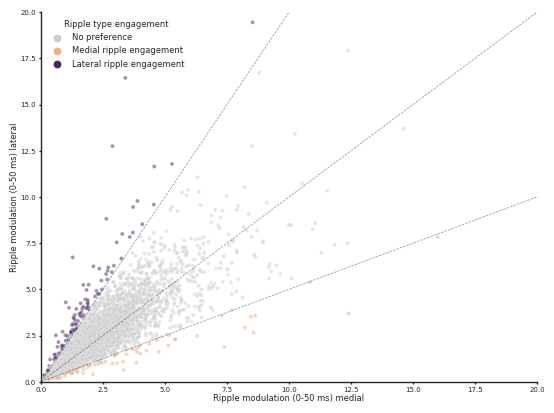

In [56]:
palette_ML['Lateral ripple engagement'] = (0.29408557, 0.13721193, 0.38442775)
palette_ML['Medial ripple engagement'] = (0.92891402, 0.68494686, 0.50173994)
palette_ML['No preference'] = (0.8,.8,.8)


<AxesSubplot:ylabel='Ripple type engagement'>

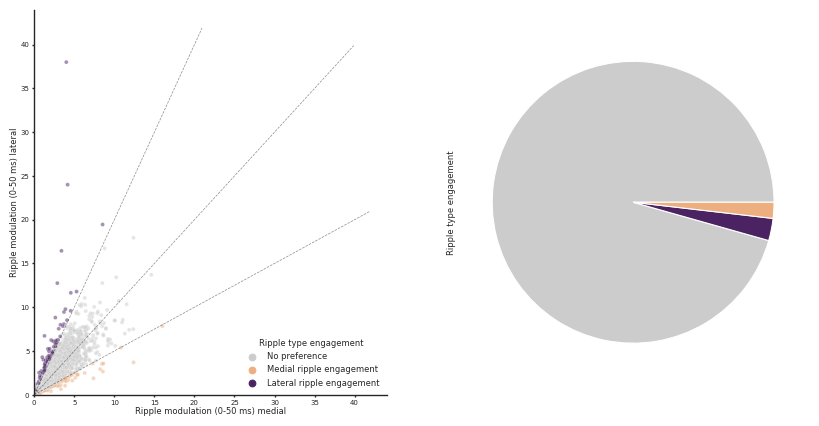

In [57]:
fig, axs = plt.subplots(1)
sns.scatterplot(data=summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& (summary_units_df_sub['Parent brain region']=='HPF')],\
               x='Ripple modulation (0-50 ms) medial', y= 'Ripple modulation (0-50 ms) lateral', \
                alpha=.5, ax=axs, s=8, hue='Ripple type engagement', palette=palette_ML)
axs.plot([0, axs.get_ylim()[1]], [0, axs.get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs.plot([0, axs.get_ylim()[1]], [0, axs.get_ylim()[1]/2],  alpha=.5, linestyle='--', color='k')
axs.plot([0, axs.get_ylim()[1]/2], [0, axs.get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs.set_xlim((0,20))
axs.set_ylim((0,20))

Text(0.5, 1.0, 'Ripple type engagement')

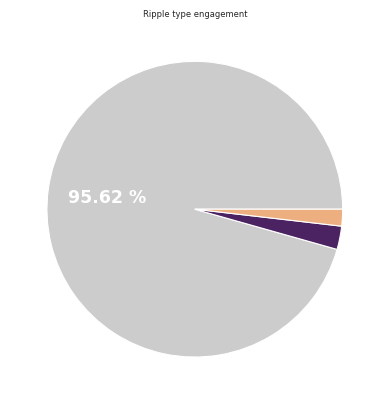

In [58]:
fig, axs = plt.subplots(1,2,  figsize=(10,5))
sns.scatterplot(data=summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& (summary_units_df_sub['Parent brain region']=='HPF' )],
               x='Ripple modulation (0-50 ms) medial', y= 'Ripple modulation (0-50 ms) lateral', alpha=.5, ax=axs[0], s=8, hue='Ripple type engagement', palette=palette_ML)
axs[0].plot([0, axs[0].get_ylim()[1]], [0, axs[0].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[0].plot([0, axs[0].get_ylim()[1]], [0, axs[0].get_ylim()[1]/2],  alpha=.5, linestyle='--', color='k')
axs[0].plot([0, axs[0].get_ylim()[1]/2], [0, axs[0].get_ylim()[1]],  alpha=.5, linestyle='--', color='k')
axs[0].set_xlim((0,axs[0].get_xlim()[1]))
axs[0].set_ylim((0,axs[0].get_ylim()[1]))

_ = pd.DataFrame(summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' )]['Ripple type engagement'].value_counts())

_.plot.pie(y= 'Ripple type engagement', ax=axs[1], colors=[palette_ML[key] for key in _.index], labels=None, legend=False)

In [70]:
_ = pd.DataFrame(summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' )]['Ripple type engagement'].value_counts())

def my_autopct(pct):
    return ('%.2f'  % pct + " %") if pct > 20 else ''

fig, ax = plt.subplots()
_, _, autopcts = ax.pie(_.values.squeeze(),colors=[palette_ML[key] for key in _.index], autopct=my_autopct)

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})

ax.xaxis.set_label_position('top')
ax.set_title('Ripple type engagement')


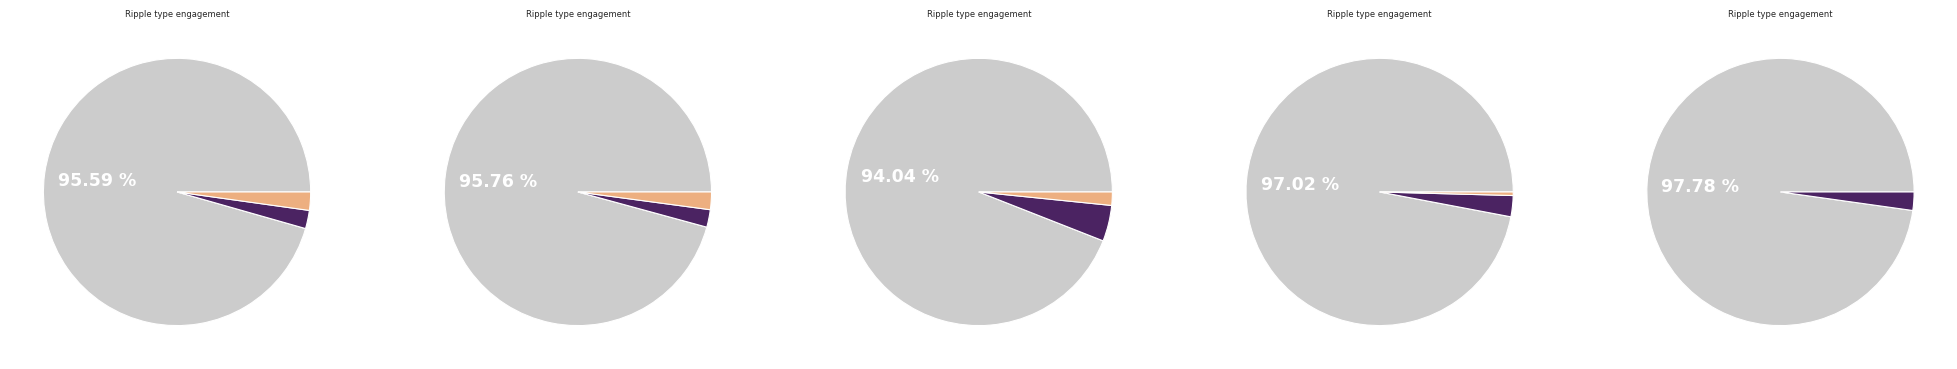

In [80]:
data = pd.DataFrame(summary_units_df_sub[(summary_units_df_sub['Firing rate (0-120 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' )].groupby('Brain region')['Ripple type engagement'].value_counts())

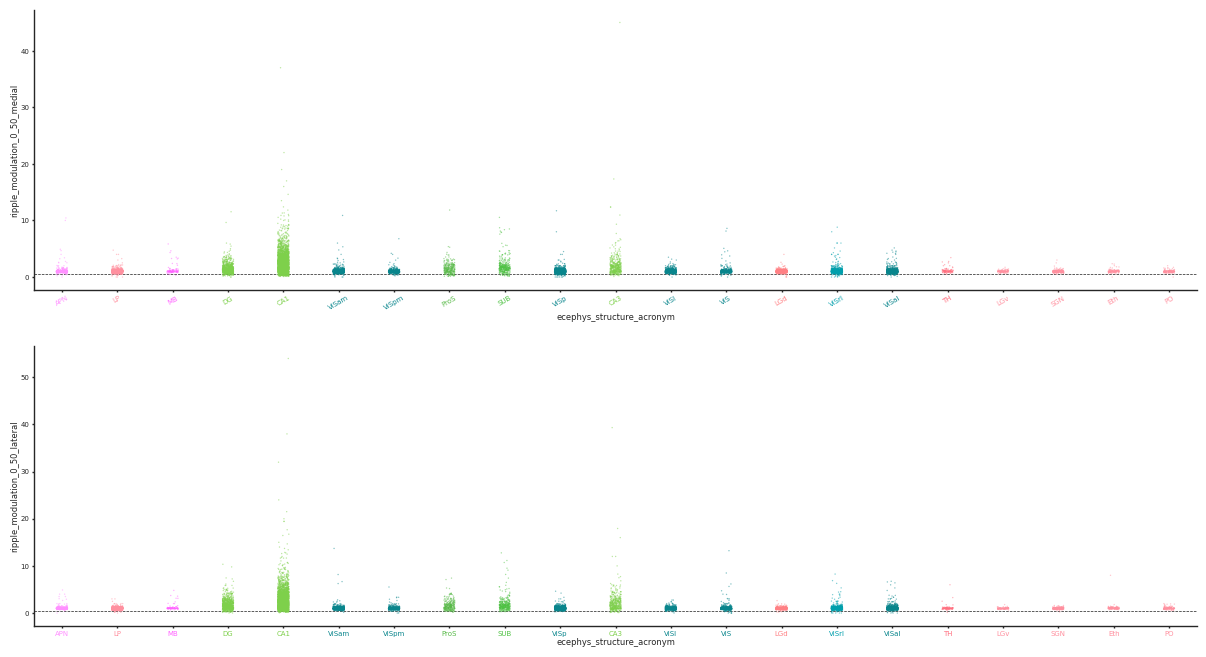

In [35]:
fig, axs = plt.subplots(1,5, figsize=(25,20))
axs = axs.ravel()

def my_autopct(pct):
    return ('%.2f'  % pct + " %") if pct > 20 else ''


for q, area in zip(range(5), data.index.get_level_values('Brain region').unique()):

    _, _, autopcts = axs[q].pie(data.loc[area].values.squeeze(), colors=[palette_ML[key] for key in data.loc[area].index], autopct=my_autopct)

    plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':12.5})

    axs[q].xaxis.set_label_position('top')
    axs[q].set_title('Ripple type engagement')

In [ ]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5, color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub, y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=1, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub, y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=1, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

0.04243243243243243

In [50]:
summary_units_df_sub[(summary_units_df_sub['Firing rate (100-0 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' ) & (summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5)].shape[0]/\
summary_units_df_sub[(summary_units_df_sub['Firing rate (100-0 ms) medial']>0.025)& 
                     (summary_units_df_sub['Parent brain region']=='HPF' ) ].shape[0]

(<matplotlib.patches.Rectangle at 0x7ff77817c9d0>,
 (<matplotlib.patches.ConnectionPatch at 0x7ff778137950>,
  <matplotlib.patches.ConnectionPatch at 0x7ff77812c950>))

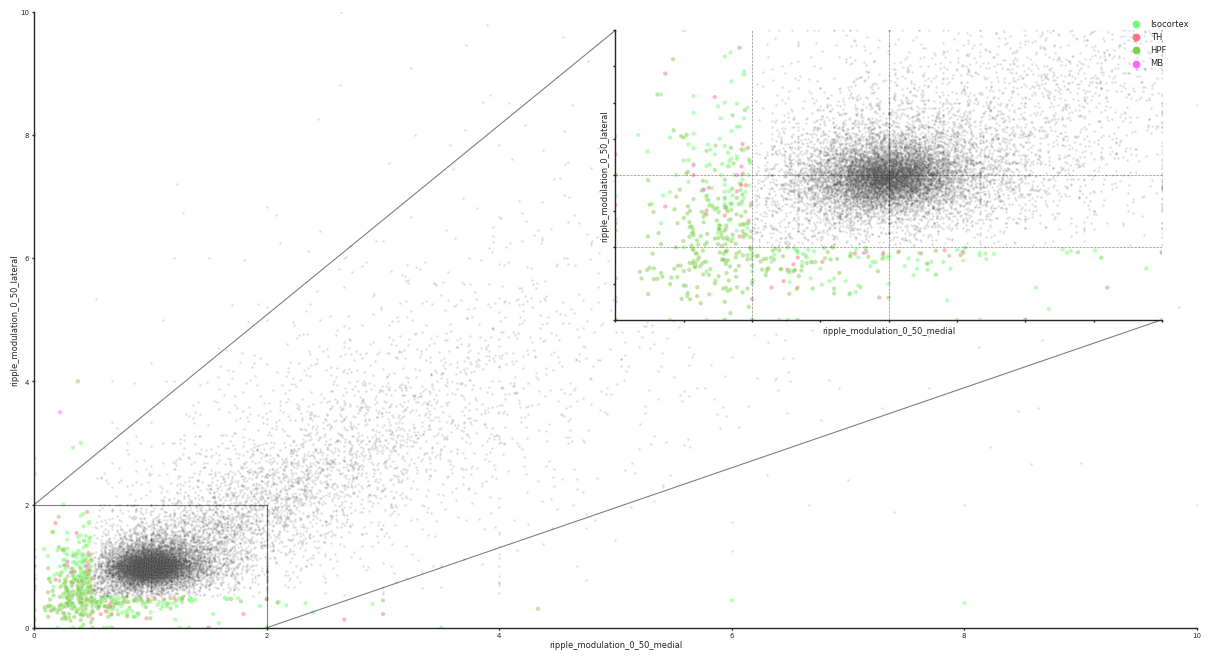

In [211]:
summary_units_df_sub['Firing rate (100-20 ms)'] = (summary_units_df_sub['Firing rate (100-20 ms) medial']+summary_units_df_sub['Firing rate (100-20 ms) lateral'])/2

(<matplotlib.patches.Rectangle at 0x7f2c2379a210>,
 (<matplotlib.patches.ConnectionPatch at 0x7f2c222eead0>,
  <matplotlib.patches.ConnectionPatch at 0x7f2c222ec2d0>))

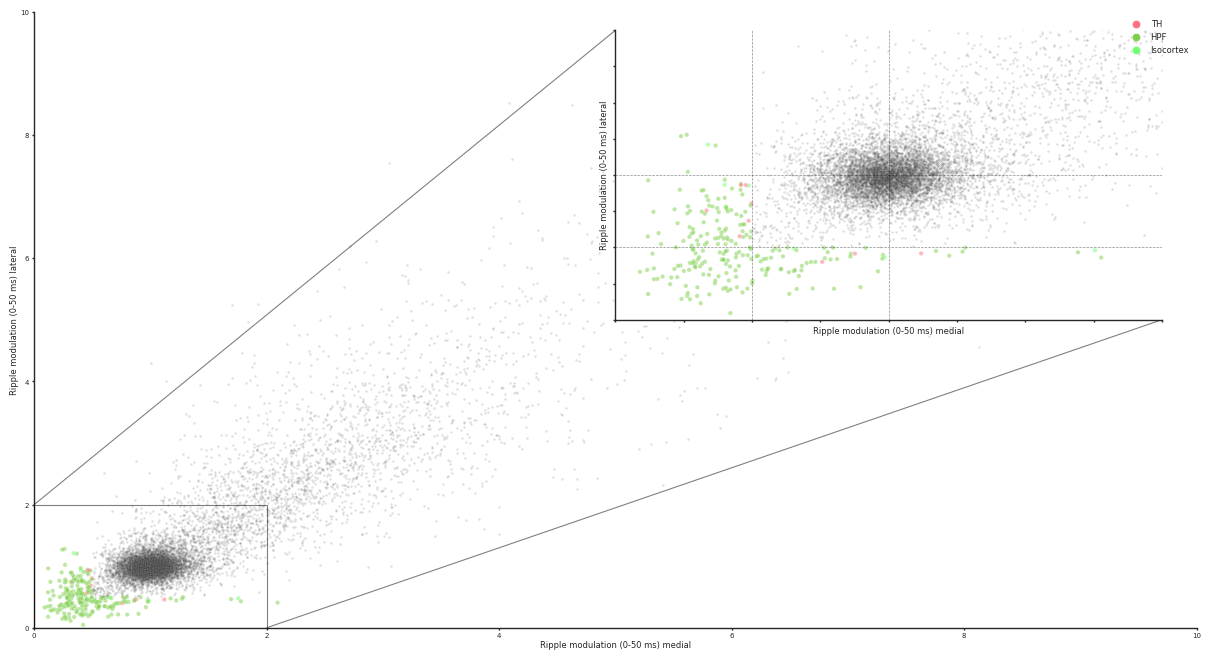

In [51]:
fig, axs = plt.subplots( 1 ,figsize=(15,8))
_ = summary_units_df_sub[summary_units_df_sub['Firing rate (100-20 ms)']>0.025]
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axs)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axs)
axs.set_xlim((0,10))
axs.set_ylim((0,10))

axins = axs.inset_axes([0.5, 0.5, 0.47, 0.47])
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axins, legend=False)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axins, legend=False)
# subregion of the original image
x1, x2, y1, y2 = 0, 2, 0, 2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.axvline(.5,  alpha=.5, linestyle='--', color='k')
axins.axhline(.5,  alpha=.5, linestyle='--', color='k')
axins.axvline(1,  alpha=.5, linestyle='--', color='k')
axins.axhline(1,  alpha=.5, linestyle='--', color='k')

axs.indicate_inset_zoom(axins, edgecolor='black')


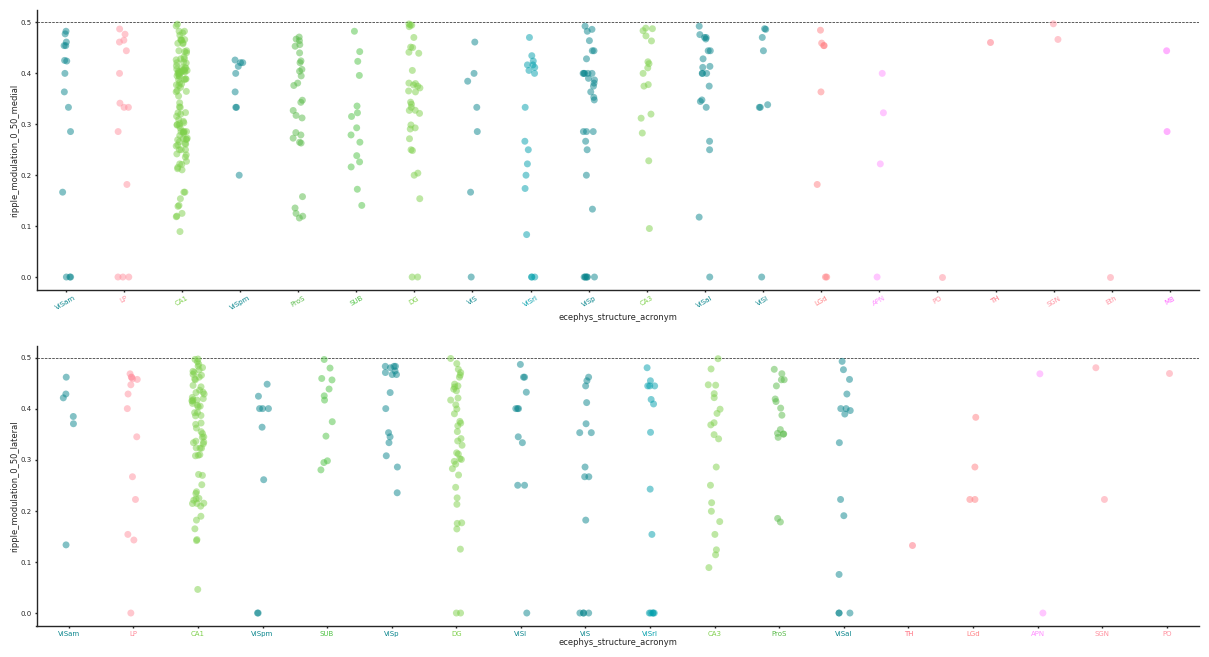

In [36]:
fig, axs = plt.subplots( 1 ,figsize=(15,8))
_ = summary_units_df_sub[summary_units_df_sub['Firing rate (100-20 ms)']>0.025]
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axs)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axs)
axs.set_xlim((0,10))
axs.set_ylim((0,10))

axins = axs.inset_axes([0.5, 0.5, 0.47, 0.47])
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']<.5) | (_['Ripple modulation (0-50 ms) lateral']<.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', hue='Parent brain region', palette=palette_parent_areas, s=10, alpha=.5, ax=axins, legend=False)
sns.scatterplot(data=_[(_['Ripple modulation (0-50 ms) medial']>.5) & (_['Ripple modulation (0-50 ms) lateral']>.5)], x='Ripple modulation (0-50 ms) medial',
                y='Ripple modulation (0-50 ms) lateral', color='.15', s=3, alpha=.15, ax=axins, legend=False)
# subregion of the original image
x1, x2, y1, y2 = 0, 2, 0, 2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.axvline(.5,  alpha=.5, linestyle='--', color='k')
axins.axhline(.5,  alpha=.5, linestyle='--', color='k')
axins.axvline(1,  alpha=.5, linestyle='--', color='k')
axins.axhline(1,  alpha=.5, linestyle='--', color='k')

axs.indicate_inset_zoom(axins, edgecolor='black')


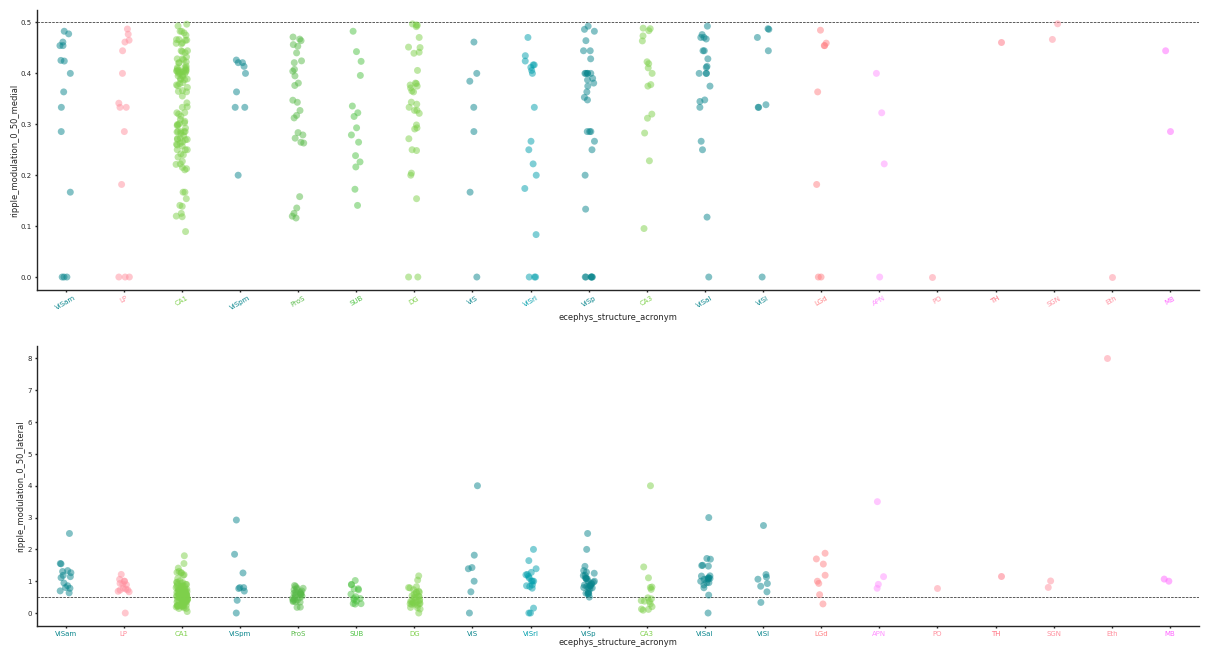

In [37]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5,color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5], y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) lateral']<.5], y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

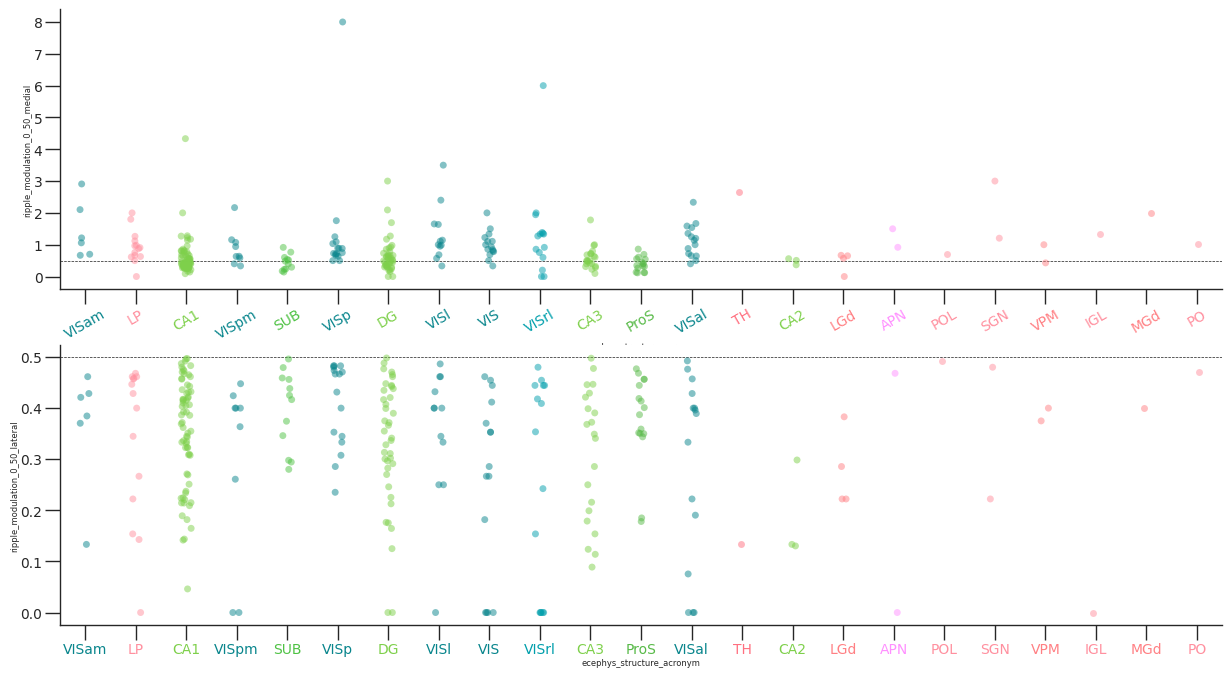

In [912]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5,color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5], y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) medial']<.5], y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

In [53]:
fig, axs = plt.subplots( 2, figsize=(15,8))
axs[0].axhline(.5,color= 'k', linestyle='--')
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) lateral']<.5], y='Ripple modulation (0-50 ms) medial', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[0])
color_to_labels(axs[0], 'x', 'major', 1);
sns.stripplot(data=summary_units_df_sub[summary_units_df_sub['Ripple modulation (0-50 ms) lateral']<.5], y='Ripple modulation (0-50 ms) lateral', x='Brain region', palette=palette_areas, alpha=.5, s=5, ax=axs[1])
color_to_labels(axs[1], 'x', 'major', 1);
axs[1].axhline(.5,color= 'k', linestyle='--')

props = {'rotation' : 30}
plt.setp(axs[0].get_xticklabels(), **props);
plt.setp(axs[0].get_xticklabels(), **props);

,left_right_ccf_coordinate,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate
diff_ripple_modulation_0_50,0.055824,0.021963,0.039599


In [ ]:
summary_units_df_sub[summary_units_df_sub['Brain region']=='CA1'][['Diff ripple modulation (0-50 ms)','M-L',
                                                                                'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate']].corr().loc[['Diff ripple modulation (0-50 ms)']
                                                                                , ['M-L',
                                                                                'anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate']]**2
                                                                                